# Introduction

In [80]:
# Import relevant libraries
import pandas as pd
import numpy as np
import os
import glob
import datetime as dt


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Markdown, display
pd.options.display.max_columns = None

from sklearn import ensemble, preprocessing
from sklearn.neighbors import KernelDensity

In [81]:
# Define function to print in markdown style
def printmd(string):
    display(Markdown(string))

## Read input data

In [82]:
# Read dataframes
df_train = pd.read_csv(r'..\Input\train.csv', parse_dates=['Date'])
df_test = pd.read_csv(r'..\Input\test.csv', parse_dates=['Date'])
df_weather = pd.read_csv(r'..\Input\weather.csv', parse_dates=['Date'])
df_sample = pd.read_csv(r'..\Input\sampleSubmission.csv')
df_spray = pd.read_csv(r'..\Input\spray.csv', parse_dates=['Date'])
map = np.loadtxt(r'..\Input\mapdata_copyright_openstreetmap_contributors.txt')

### Get target labels

In [83]:
# Get target labels
labels = df_train['WnvPresent'].values

### Define map visualisayion parameters

In [84]:
alpha_cm = plt.cm.Reds
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]
aspect = map.shape[0] * 1.0 / map.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)
alpha_mcm = plt.cm.Greens
alpha_mcm._init()
alpha_mcm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

# EDA

## Introductory dataset analysis

In [85]:
perc_pos = sum(1 for i in labels if i == 1)/len(labels)

### Percentage of positives

In [86]:
printmd('{0:.2f}% of the training rows are positive.'.format(perc_pos*100))

5.24% of the training rows are positive.

### Training dataset size

In [87]:
df_train.shape

(10506, 12)

### Duplicate readings

In [88]:
df_train.drop_duplicates().shape

(9693, 12)

In [89]:
df_train[df_train.duplicated(df_train.columns)==True].shape

(813, 12)

### Unique species

In [90]:
df_train['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

### Date ranges

In [96]:
printmd('The training dataset spans dates from {} to {}.'.format(df_train['Date'].min().date(), df_train['Date'].max().date()))

The training dataset spans dates from 2007-05-29 to 2013-09-26.

In [97]:
printmd('The testing dataset spans dates from {} to {}.'.format(df_test['Date'].min().date(), df_test['Date'].max().date()))

The testing dataset spans dates from 2008-06-11 to 2014-10-02.

## Comparing means across groups

In [54]:
df_train.groupby('WnvPresent').median()

Block   Latitude  Longitude  AddressAccuracy  NumMosquitos
WnvPresent                                                            
0              33  41.846075 -87.694259                8             4
1              36  41.903002 -87.725057                8            24

In [55]:
df_train.groupby('WnvPresent').mean()

Block   Latitude  Longitude  AddressAccuracy  NumMosquitos
WnvPresent                                                                
0           35.659869  41.840378 -87.698538         7.816775     12.106479
1           36.192377  41.854891 -87.724663         7.869328     26.350272

In [56]:
# Check for missing values
df_train.isnull().any()

Date                      False
Address                   False
Species                   False
Block                     False
Street                    False
Trap                      False
AddressNumberAndStreet    False
Latitude                  False
Longitude                 False
AddressAccuracy           False
NumMosquitos              False
WnvPresent                False
dtype: bool

In [57]:
df_train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [58]:
df_train['AddressAccuracy'].describe()

count    10506.000000
mean         7.819532
std          1.452921
min          3.000000
25%          8.000000
50%          8.000000
75%          9.000000
max          9.000000
Name: AddressAccuracy, dtype: float64

## Exploring variable correlation

Block  Latitude  Longitude  AddressAccuracy  NumMosquitos  \
Block            1.000000  0.091110  -0.090375         0.222134     -0.172388   
Latitude         0.091110  1.000000  -0.701795         0.444026     -0.184806   
Longitude       -0.090375 -0.701795   1.000000        -0.456775      0.036633   
AddressAccuracy  0.222134  0.444026  -0.456775         1.000000     -0.248414   
NumMosquitos    -0.172388 -0.184806   0.036633        -0.248414      1.000000   
WnvPresent       0.004877  0.028697  -0.060345         0.008064      0.196820   

                 WnvPresent  
Block              0.004877  
Latitude           0.028697  
Longitude         -0.060345  
AddressAccuracy    0.008064  
NumMosquitos       0.196820  
WnvPresent         1.000000

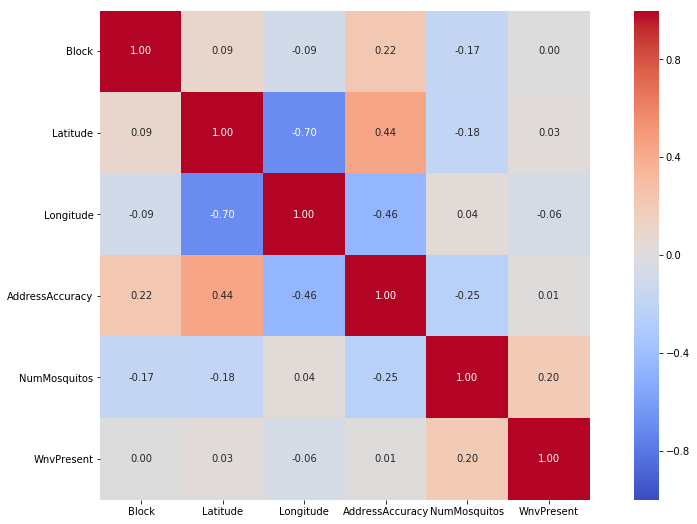

In [59]:
#Correlation Matrix
df_corr = df_train.corr()
plt.figure(figsize=(16,9))
sns.heatmap(df_corr, vmin = -1, vmax = 1, square=True, annot=True, fmt='.2f', cmap='coolwarm');

df_corr

Number of mosquitoes seems to be the only variable with a small correlation to the target variable.

## WNV by species

Text(0,0.5,'Number of measurements')

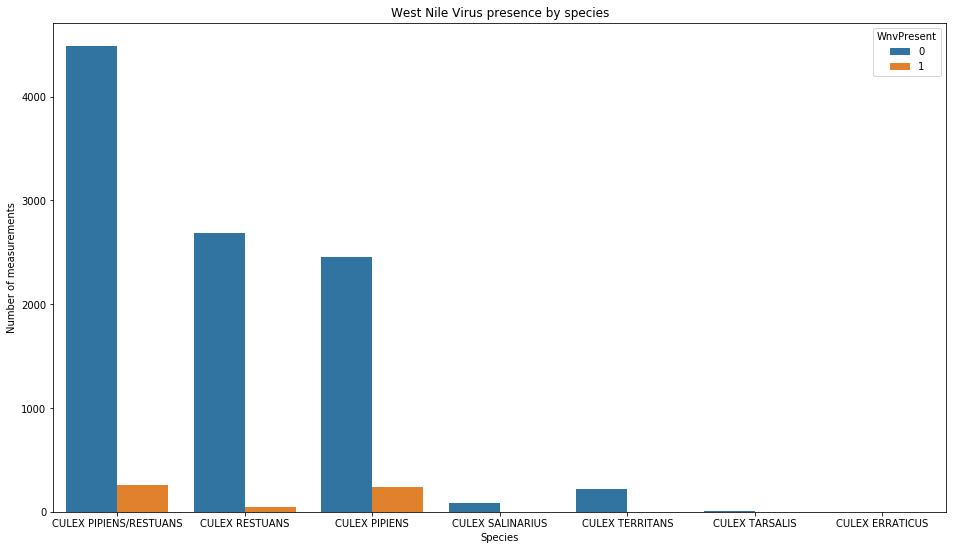

In [60]:
plt.figure(figsize=(16,9))
ax = sns.countplot(x='Species', hue='WnvPresent', data=df_train).set_title('West Nile Virus presence by species')
plt.xlabel('Species')
plt.ylabel('Number of measurements')

## WNV by date

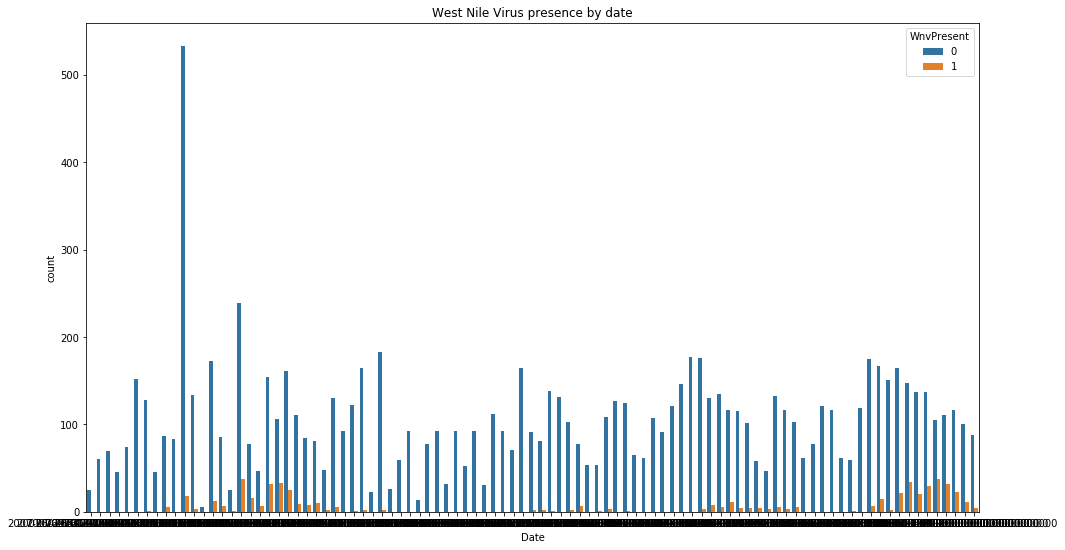

In [61]:
plt.figure(figsize=(16,9))
ax = sns.countplot(x='Date', hue='WnvPresent', data=df_train).set_title('West Nile Virus presence by date')

## Exploring virus presence across traps

In [99]:
df_train.groupby('Trap')['WnvPresent'].mean().sort_values(ascending=False)

Trap
T143     0.193548
T006     0.166667
T005     0.142857
T233     0.140000
T014     0.133333
T096     0.120000
T003     0.114754
T015     0.114286
T235     0.112903
T054C    0.111111
T230     0.107692
T225     0.106796
T016     0.106061
T223     0.103448
T070     0.100000
T002     0.097297
T228     0.096774
T013     0.096154
T154     0.095238
T231     0.095238
T086     0.093023
T107     0.090909
T900     0.088000
T045     0.085714
T011     0.082707
T082     0.081633
T009     0.081081
T221     0.080357
T061     0.077670
T028     0.076923
           ...   
T238     0.000000
T025     0.000000
T019     0.000000
T219     0.000000
T129     0.000000
T040     0.000000
T078     0.000000
T100     0.000000
T099     0.000000
T141     0.000000
T094B    0.000000
T092     0.000000
T146     0.000000
T088     0.000000
T148     0.000000
T149     0.000000
T150     0.000000
T076     0.000000
T043     0.000000
T075     0.000000
T072     0.000000
T071     0.000000
T153     0.000000
T157     0.000000
T060 

# Visualising data

## Virus occurence heatmap by year

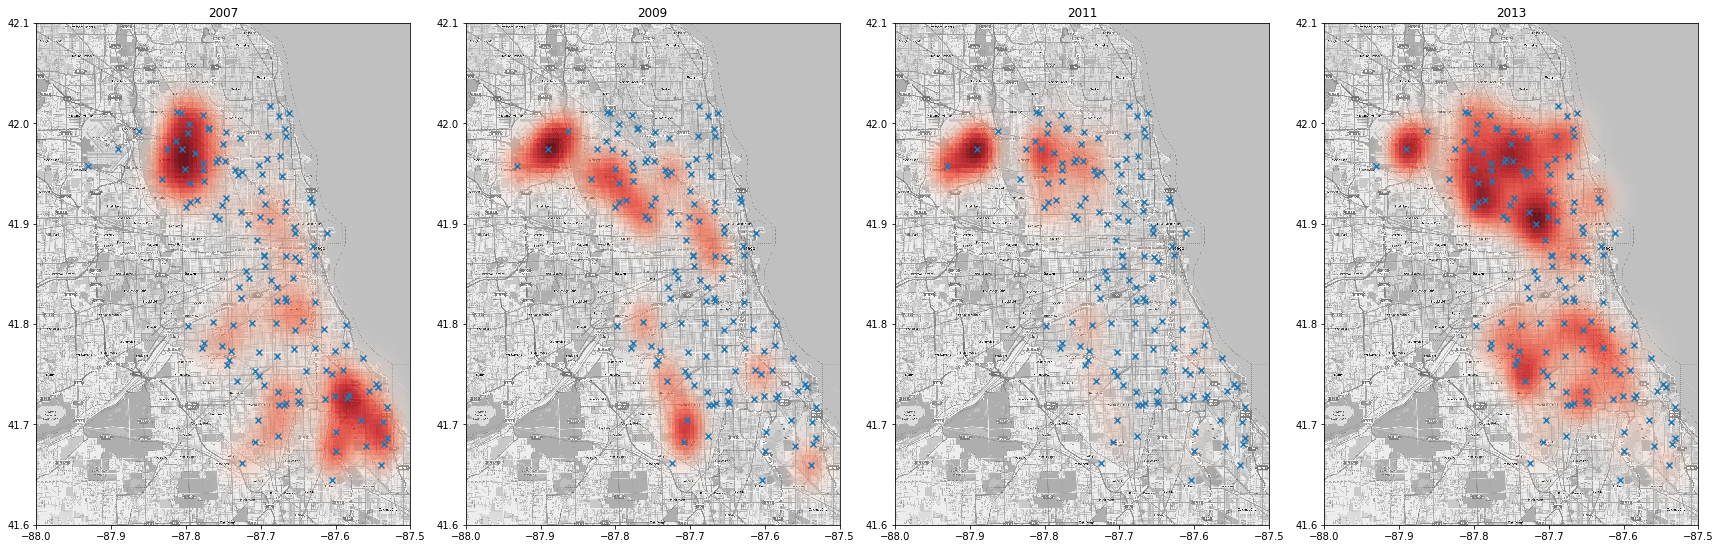

In [47]:
plt.figure(figsize=(24,9))
for year, subplot in zip([2007, 2009, 2011, 2013], [141, 142, 143, 144]):
    positives = df_train[(df_train['WnvPresent'] > 0) & (df_train['Date'].dt.year == year)].groupby(['Date', 'Trap','Longitude', 'Latitude']).max()['WnvPresent'].reset_index()
    X = positives[['Longitude', 'Latitude']].values
    kd = KernelDensity(bandwidth=0.02)
    kd.fit(X)

    xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(),yv.ravel()]).T
    zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
    plt.subplot(subplot)
    plt.gca().set_title(year)
    plt.imshow(map, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.imshow(zv, 
               origin='lower', 
               cmap=alpha_cm, 
               extent=lon_lat_box, 
               aspect=aspect)
    plt.tight_layout()
    locations = df_train[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(locations[:,0], locations[:,1], marker='x')

## Spray heatmap by species and year

In [48]:
def plotHeatMap(data, a_cm):
    if(len(data) > 0):
        X = data[['Longitude', 'Latitude']].values
        kd = KernelDensity(bandwidth=0.02)
        kd.fit(X)
        xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
        gridpoints = np.array([xv.ravel(),yv.ravel()]).T
        zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))
        plt.imshow(zv, 
                   origin='lower', 
                   cmap=a_cm, 
                   extent=lon_lat_box, 
                   aspect=aspect)

         [1]:2007 (CULEX PIPIENS/RESTUANS)
         [2]:2009 (CULEX PIPIENS/RESTUANS)
         [3]:2011 (CULEX PIPIENS/RESTUANS)
         [4]:2013 (CULEX PIPIENS/RESTUANS)
         [5]:2007 (CULEX RESTUANS)
         [6]:2009 (CULEX RESTUANS)
         [7]:2011 (CULEX RESTUANS)
         [8]:2013 (CULEX RESTUANS)
         [9]:2007 (CULEX PIPIENS)
         [10]:2009 (CULEX PIPIENS)
         [11]:2011 (CULEX PIPIENS)
         [12]:2013 (CULEX PIPIENS)
         [13]:2007 (CULEX SALINARIUS)
         [14]:2009 (CULEX SALINARIUS)
         [15]:2011 (CULEX SALINARIUS)
         [16]:2013 (CULEX SALINARIUS)
         [17]:2007 (CULEX TERRITANS)
         [18]:2009 (CULEX TERRITANS)
         [19]:2011 (CULEX TERRITANS)
         [20]:2013 (CULEX TERRITANS)
SKIPPING [21]:2007 (CULEX TARSALIS)		No sightings
         [22]:2009 (CULEX TARSALIS)
         [23]:2011 (CULEX TARSALIS)
SKIPPING [24]:2013 (CULEX TARSALIS)		No sightings
SKIPPING [25]:2007 (CULEX ERRATICUS)		No sightings
SKIPPING [26]:2009 (CULEX 

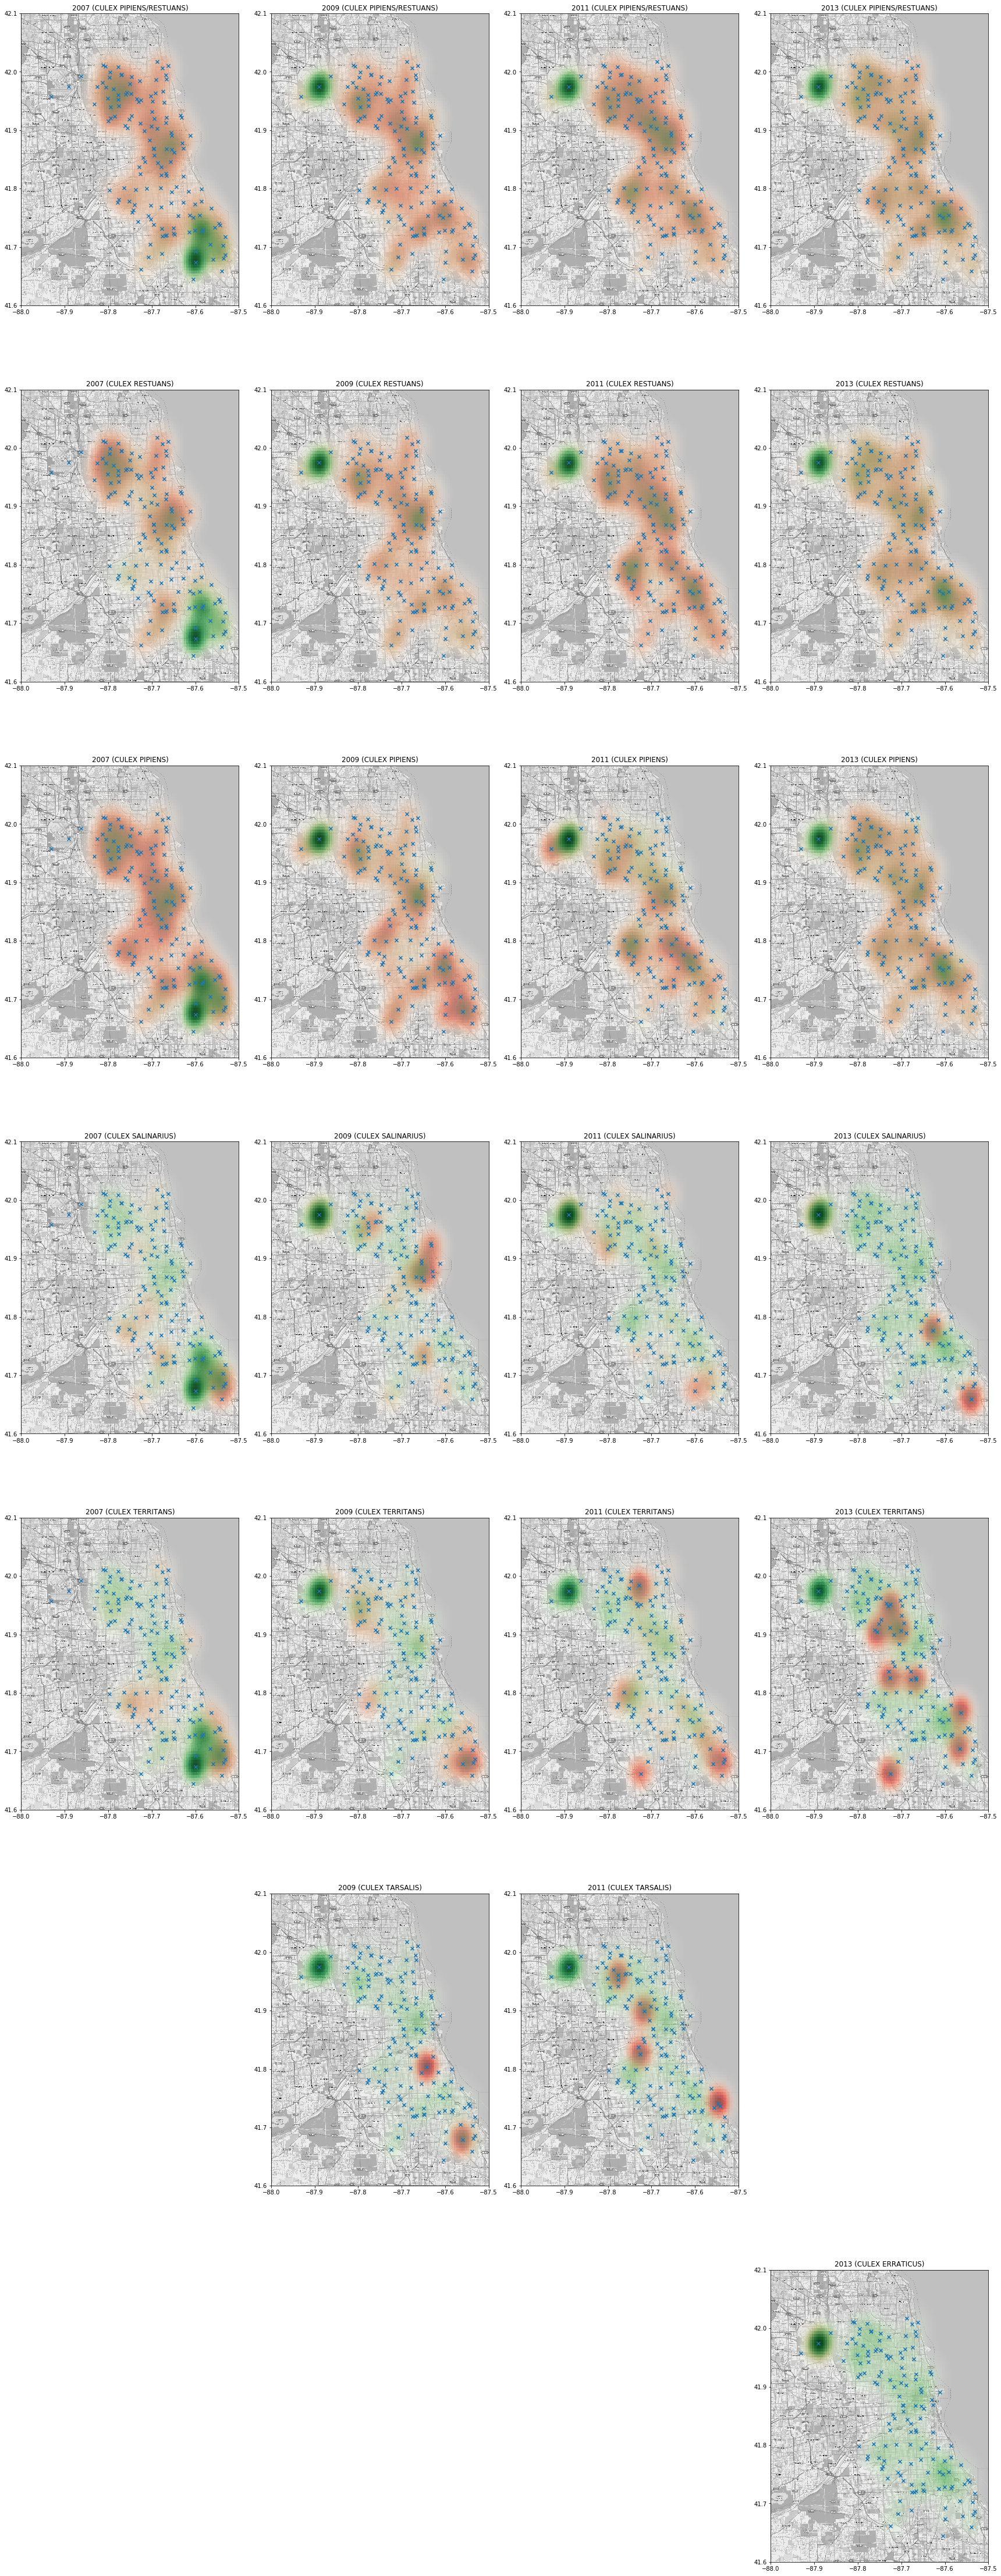

In [53]:
subplot = 0
numSpcs = len(df_train['Species'].unique())
plt.figure(figsize=(24,9*numSpcs))
for spcsIndx in range(numSpcs):
    for year in [2007, 2009, 2011, 2013]:
        subplot += 1
        positives = df_train[(df_train['Date'].dt.year == year)]
        mPositives = df_train[(df_train['Species'] == df_train['Species'].unique()[spcsIndx]) & (df_train['Date'].dt.year == year)].groupby(['Date', 'Trap', 'Longitude', 'Latitude', 'Species'])['WnvPresent'].max().reset_index()
        if(len(mPositives) <= 0):
            print("SKIPPING [" + str(subplot) + "]:" + str(year) + " (" + df_train['Species'].unique()[spcsIndx] + ")\t\tNo sightings")
            continue

        plt.subplot(numSpcs, 4, subplot)
        plt.gca().set_title(str(year) + " (" + df_train['Species'].unique()[spcsIndx] + ")")
        plt.imshow(map, 
                   cmap=plt.get_cmap('gray'), 
                   extent=lon_lat_box, 
                   aspect=aspect)
        plotHeatMap(mPositives, alpha_cm)
        plotHeatMap(positives, alpha_mcm)

        print("         [" + str(subplot) + "]:" + str(year) + " (" + df_train['Species'].unique()[spcsIndx] + ")")
        plt.tight_layout()
        locations = df_train[['Longitude', 'Latitude']].drop_duplicates().values
        plt.scatter(locations[:,0], locations[:,1], marker='x')

# Predictive Models

## Random Forest

In [112]:
# Not using codesum for this benchmark
rf_weather = df_weather.drop('CodeSum', axis=1)
rf_train = df_train.copy()
rf_test = df_test.copy()

In [113]:
# Split station 1 and 2 and join horizontally
rf_weather_stn1 = rf_weather[rf_weather['Station']==1]
rf_weather_stn2 = rf_weather[rf_weather['Station']==2]
rf_weather_stn1 = rf_weather_stn1.drop('Station', axis=1)
rf_weather_stn2 = rf_weather_stn2.drop('Station', axis=1)
rf_weather = rf_weather_stn1.merge(rf_weather_stn2, on='Date')

In [114]:
# replace some missing values and T with -1
rf_weather = rf_weather.replace('M', -1)
rf_weather = rf_weather.replace('-', -1)
rf_weather = rf_weather.replace('T', -1)
rf_weather = rf_weather.replace(' T', -1)
rf_weather = rf_weather.replace('  T', -1)

In [115]:
rf_train['Month'] = rf_train['Date'].dt.month
rf_train['Day'] = rf_train['Date'].dt.day
rf_test['Month'] = rf_test['Date'].dt.month
rf_test['Day'] = rf_test['Date'].dt.day

In [116]:
# Add integer latitude/longitude columns
rf_train['Lat_int'] = rf_train.Latitude.apply(int)
rf_train['Long_int'] = rf_train.Longitude.apply(int)
rf_test['Lat_int'] = rf_test.Latitude.apply(int)
rf_test['Long_int'] = rf_test.Longitude.apply(int)

In [117]:
# drop address columns
rf_train = rf_train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
rf_test = rf_test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [118]:
# Merge with weather data
rf_train = rf_train.merge(rf_weather, on='Date')
rf_test = rf_test.merge(rf_weather, on='Date')
rf_train = rf_train.drop(['Date'], axis = 1)
rf_test = rf_test.drop(['Date'], axis = 1)

In [119]:
# Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(rf_train['Species'].values) + list(rf_test['Species'].values))
rf_train['Species'] = lbl.transform(rf_train['Species'].values)
rf_test['Species'] = lbl.transform(rf_test['Species'].values)

In [120]:
lbl.fit(list(rf_train['Street'].values) + list(rf_test['Street'].values))
rf_train['Street'] = lbl.transform(rf_train['Street'].values)
rf_test['Street'] = lbl.transform(rf_test['Street'].values)

In [121]:
lbl.fit(list(rf_train['Trap'].values) + list(rf_test['Trap'].values))
rf_train['Trap'] = lbl.transform(rf_train['Trap'].values)
rf_test['Trap'] = lbl.transform(rf_test['Trap'].values)

In [122]:
# drop columns with -1s
rf_train = rf_train.ix[:, (rf_train != -1).any(axis=0)]
rf_test = rf_test.ix[:, (rf_test != -1).any(axis=0)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [123]:
# Random Forest Classifier 
clf = ensemble.RandomForestClassifier(n_jobs=1, n_estimators=1000, min_samples_split= 2)
clf.fit(rf_train, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [77]:
# create predictions and submission file
predictions = clf.predict_proba(rf_test)[:,1]
df_sample['WnvPresent'] = predictions
df_sample.to_csv(r'..\Output\20181226_Kaggle_West Nile Virus_JG_V2.csv', index=False)